In [1]:
# --- Standard libraries
import os.path as osp
import heapq as hq
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# --- PyTorch
import torch
# --- Science python
from sklearn.metrics import mean_squared_error
from scipy.stats import wasserstein_distance, spearmanr
from utils import pred_spec, calculate_rse, bokeh_spectra
# --- Bokeh
from bokeh.io import output_notebook, show
from bokeh.layouts import row
from bokeh.models import Label
output_notebook()
# --- XASNet
from XASNet.models import XASNet_GNN, XASNet_GAT, XASNet_GraphNet
from XASNet.trainer import GNNTrainer
from XASNet.utils import GraphDataProducer
from XASNet.utils.visualisation import plot_prediction
from XASNet.utils.rse import rse_predictions, rse_loss, rse_histogram
from utils import bokeh_hist
torch.__version__

Loading BokehJS ...

'2.4.1+cu124'

#### Coronene

In [2]:
# --- Load in the test dataset
cor_test_dataset = torch.load('./processed/test_cor_xasnet.pt')

/tmp/ipykernel_18462/4233018105.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cor_test_dataset = torch.load('./processed/test_xasnet_cor.pt')


In [3]:
# --- Print details of the dataset
print(f'Number of graphs: {len(cor_test_dataset)}')
print('')

# --- Print details of the first molecule/graph in the dataset
data = cor_test_dataset[2]

print(data)
print('------------')
print(f'Molecule index: {data.idx}')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Number of graphs: 49

Data(x=[33, 6], edge_index=[2, 82], edge_attr=[82, 5], spectrum=[200], idx=[1], smiles='c12[c:2]3[c:3]([H:33])[c:6]([H:34])[c:7]4[c:5]1[c:9]1[c:13]5[c:17]6[c:21]2[C:23]([O:30][H:42])([C:22]([C:25](=[O:26])[O:27][H:40])([H:46])[C:20]([H:45])=[C:19]6[C:18]([H:44])=[C:16]([H:43])[C:15]52[C:14]([H:38])([C:12]5([H:37])[C:11]1([C:10]([H:36])=[C:8]4[H:35])[O:31]5)[O:32]2)[C:24]([H:39])=[C:1]3[C:4](=[O:28])[O:29][H:41]')
------------
Molecule index: tensor([138])
Number of nodes: 33
Number of edges: 82
Average node degree: 2.48
Has isolated nodes: False
Has self loops: False
Is undirected: True


##### XASNet GNN

In [4]:
# --- Set device for model to run on
device = 'cpu'

# --- Set ML model parameters to match the loaded model
xasnet_gnn = XASNet_GNN(
    gnn_name = 'graphConv', # model type
    in_channels = [6, 64, 128], # input nodes for each layer
    out_channels = [64, 128, 256], # output nodes for each layer
    num_targets = 200, # nodes for final layers
    num_layers = 3, # number of layers
    dropout = 0.1,
    heads = 0
).to(device)

# --- Location of the ML model
path_to_model = osp.join('./best_model/xasnet_' + xasnet_gnn.gnn_name + '_model.pt')

# --- Check if there is an existing model
if osp.exists(path_to_model):
    xasnet_gnn.load_state_dict(torch.load(path_to_model, map_location=device))
else:
    print('Model is not loaded.')

/tmp/ipykernel_18462/1394317668.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  xasnet_gnn.load_state_dict(torch.load(path_to_model, map_location=device))


##### XASNet GAT

In [86]:
# --- Set device for model to run on
device = 'cpu'

# --- Create the type of ML model you want to run
xasnet_gat = XASNet_GAT(
    node_features_dim=8,
    in_channels=[64, 128],
    out_channels=[128, 256],
    targets=200,
    n_layers=2,
    n_heads=4,
    gat_type='gatv2_custom',
    use_residuals=True,
    use_jk=True
).to(device)

# --- Location to save model
path_to_model = osp.join('./best_model/xasnet-GAT_gatv2_custom_model.pt')

# --- Check if there is an already existing model
if osp.exists(path_to_model):
    xasnet_gat.load_state_dict(torch.load(path_to_model))
else:
    print('Model is not loaded.')

/tmp/ipykernel_32413/1780165026.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  xasnet_gat.load_state_dict(torch.load(path_to_model))


##### XASNet GraphNet

In [4]:
# --- Set device for model to run on
device = 'cpu'

# --- Create the type of ML model you want to run
xasnet_graphnet = XASNet_GraphNet(
    node_dim=8,
    edge_dim=5,
    hidden_channels=64,
    out_channels=128,
    gat_hidd=64,
    gat_out=128,
    n_layers=3,
    n_targets=200
).to(device)

# --- Location to save model
path_to_model = osp.join('./best_model/xasnet_graphnet_model.pt')

# --- Check if there is an already existing model
if osp.exists(path_to_model):
    xasnet_graphnet.load_state_dict(torch.load(path_to_model))
else:
    print('Model is not loaded.')

/tmp/ipykernel_3912/3116478464.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  xasnet_graphnet.load_state_dict(torch.load(path_to_model))


##### View Predictions

In [5]:
cor_predict = {}
cor_true = {}

for data in enumerate(cor_test_dataset):
    cor_predict[data[0]], cor_true[data[0]] = pred_spec(xasnet_gnn, data, cor_test_dataset, graphnet=False)

In [6]:
cor_wasser = []
cor_mse = []
cor_rse = []
cor_spear = []

for x in range(len(cor_predict)):
    # Wasserstein metric
    wass_temp = wasserstein_distance(cor_true[x], cor_predict[x])
    cor_wasser.append(wass_temp)
    # Mean squared error
    mse_temp = mean_squared_error(cor_true[x], cor_predict[x])
    cor_mse.append(mse_temp)
    # RSE
    rse_temp = calculate_rse(cor_true[x], cor_predict[x])
    cor_rse.append(rse_temp)
    # Spearman coefficient
    spear_temp = spearmanr(cor_true[x], cor_predict[x])
    cor_spear.append(spear_temp[0])

print(f"Average Wasserstein distance = {sum(cor_wasser) / len(cor_wasser)}")
print(f'Average spearman correlation coefficient = {sum(cor_spear) / len(cor_spear)}')
print(f"Average MSE = {sum(cor_mse) / len(cor_mse)}")
print(f'Average RSE = {sum(cor_rse) / len(cor_rse)}')

Average Wasserstein distance = 0.0423197000938291
Average spearman correlation coefficient = 0.9428483263101987
Average MSE = 0.00849211122840643
Average RSE = 0.04163384065032005


In [7]:
cor_rank_rse = hq.nsmallest(49, cor_rse)

cor_rank_graph = []

for x in range(48):
    cor_rank_idx = cor_rse.index(cor_rank_rse[x])
    cor_rank_graph.append(cor_rank_idx)

print('The 5 best RSE values are:')
for x in range(5):
    print(f'RSE = {cor_rank_rse[x]:.4f}, graph number = {cor_rank_graph[x]}')

print('')
print('The 5 worst RSE values are:')
for x in range(-1, -6, -1):
    print(f'RSE = {cor_rank_rse[x]:.4f}, graph number = {cor_rank_graph[x]}')

The 5 best RSE values are:
RSE = 0.0245, graph number = 14
RSE = 0.0261, graph number = 39
RSE = 0.0272, graph number = 44
RSE = 0.0279, graph number = 31
RSE = 0.0288, graph number = 26

The 5 worst RSE values are:
RSE = 0.0910, graph number = 10
RSE = 0.0640, graph number = 41
RSE = 0.0630, graph number = 35
RSE = 0.0600, graph number = 8
RSE = 0.0594, graph number = 25


In [8]:
df = pd.read_pickle('./coronene_rse_values_sd1994.pkl')

df[xasnet_gnn.gnn_name] = cor_rse

In [9]:
df.to_pickle('./coronene_rse_values_sd1994.pkl')

In [10]:
# --- Plot best spectra prediction
p1 = bokeh_spectra(cor_predict[cor_rank_graph[0]], cor_true[cor_rank_graph[0]])
p2 = bokeh_spectra(cor_predict[cor_rank_graph[1]], cor_true[cor_rank_graph[1]])
p3 = bokeh_spectra(cor_predict[cor_rank_graph[2]], cor_true[cor_rank_graph[2]])
p = row(p1, p2, p3)
show(p)
#export_png(p, filename='GO_mol_best_RSE.png')

In [11]:
# --- Plot worst spectra prediction
p1 = bokeh_spectra(cor_predict[cor_rank_graph[-1]], cor_true[cor_rank_graph[-1]])
p2 = bokeh_spectra(cor_predict[cor_rank_graph[-2]], cor_true[cor_rank_graph[-2]])
p3 = bokeh_spectra(cor_predict[cor_rank_graph[-3]], cor_true[cor_rank_graph[-3]])
p = row(p1, p2, p3)
show(p)
#export_png(p, filename='GO_mol_best_RSE.png')

#### Circumcoronene

In [12]:
# --- Load in the test dataset
circ_test_dataset = torch.load('./processed/test_circ_xasnet.pt')

/tmp/ipykernel_18462/4099427338.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  circ_test_dataset = torch.load('./processed/test_circ_xasnet.pt')


In [13]:
circ_predict = {}
circ_true = {}

for data in enumerate(circ_test_dataset):
    circ_predict[data[0]], circ_true[data[0]] = pred_spec(xasnet_gnn, data, circ_test_dataset, graphnet=False)

In [14]:
circ_wasser = []
circ_mse = []
circ_rse = []
circ_spear = []

for x in range(len(circ_predict)):
    # Wasserstein metric
    wass_temp = wasserstein_distance(circ_true[x], circ_predict[x])
    circ_wasser.append(wass_temp)
    # Mean squared error
    mse_temp = mean_squared_error(circ_true[x], circ_predict[x])
    circ_mse.append(mse_temp)
    # RSE
    rse_temp = calculate_rse(circ_true[x], circ_predict[x])
    circ_rse.append(rse_temp)
    # Spearman coefficient
    spear_temp = spearmanr(circ_true[x], circ_predict[x])
    circ_spear.append(spear_temp[0])

print(f"Average Wasserstein distance = {sum(circ_wasser) / len(circ_wasser)}")
print(f'Average spearman correlation coefficient = {sum(circ_spear) / len(circ_spear)}')
print(f"Average MSE = {sum(circ_mse) / len(circ_mse)}")
print(f'Average RSE = {sum(circ_rse) / len(circ_rse)}')

Average Wasserstein distance = 0.06403074274485762
Average spearman correlation coefficient = 0.9800535562839621
Average MSE = 0.008132067508995533
Average RSE = 0.047258876264095306


In [15]:
circ_rank_rse = hq.nsmallest(91, circ_rse)

circ_rank_graph = []

for x in range(91):
    circ_rank_idx = circ_rse.index(circ_rank_rse[x])
    circ_rank_graph.append(circ_rank_idx)

print('The 5 best RSE values are:')
for x in range(5):
    print(f'RSE = {circ_rank_rse[x]:.4f}, graph number = {circ_rank_graph[x]}')

print('')
print('The 5 worst RSE values are:')
for x in range(-1, -6, -1):
    print(f'RSE = {circ_rank_rse[x]:.4f}, graph number = {circ_rank_graph[x]}')

The 5 best RSE values are:
RSE = 0.0240, graph number = 49
RSE = 0.0271, graph number = 47
RSE = 0.0298, graph number = 37
RSE = 0.0305, graph number = 55
RSE = 0.0307, graph number = 17

The 5 worst RSE values are:
RSE = 0.0774, graph number = 77
RSE = 0.0715, graph number = 34
RSE = 0.0683, graph number = 44
RSE = 0.0679, graph number = 58
RSE = 0.0644, graph number = 25


In [16]:
df = pd.read_pickle('./circ_rse_values_sd1994.pkl')

df[xasnet_gnn.gnn_name] = circ_rse

In [17]:
df.to_pickle('./circ_rse_values_sd1994.pkl')

In [18]:
# --- Plot best spectra prediction
p1 = bokeh_spectra(circ_predict[circ_rank_graph[0]], circ_true[circ_rank_graph[0]])
p2 = bokeh_spectra(circ_predict[circ_rank_graph[1]], circ_true[circ_rank_graph[1]])
p3 = bokeh_spectra(circ_predict[circ_rank_graph[2]], circ_true[circ_rank_graph[2]])
p = row(p1, p2, p3)
show(p)
#export_png(p, filename='GO_mol_best_RSE.png')

In [19]:
# --- Plot worst spectra prediction
p1 = bokeh_spectra(circ_predict[circ_rank_graph[-1]], circ_true[circ_rank_graph[-1]])
p2 = bokeh_spectra(circ_predict[circ_rank_graph[-2]], circ_true[circ_rank_graph[-2]])
p3 = bokeh_spectra(circ_predict[circ_rank_graph[-3]], circ_true[circ_rank_graph[-3]])
p = row(p1, p2, p3)
show(p)
#export_png(p, filename='GO_mol_best_RSE.png')

### Boxplot

In [20]:
cor_df = pd.read_pickle('./coronene_rse_values_sd1994.pkl')
circ_df = pd.read_pickle('./circ_rse_values_sd1994.pkl')

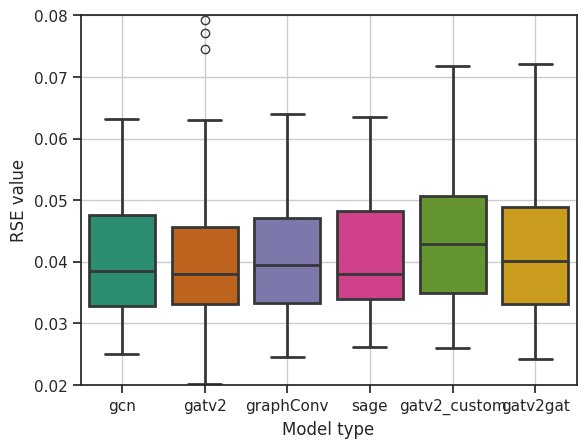

In [21]:
sns.set_style('white')
sns.set_context('notebook')
sns.set_style('ticks')
sns.boxplot(data=cor_df, palette='Dark2', linewidth=2)
plt.grid()
plt.ylim(0.02, 0.08)
plt.ylabel('RSE value')
plt.xlabel('Model type')
plt.show()

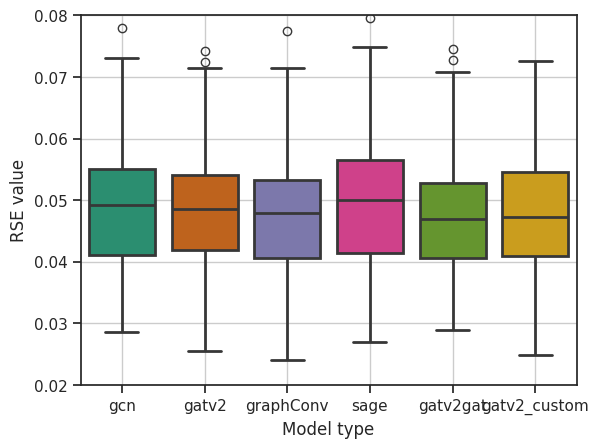

In [22]:
sns.set_style('white')
sns.set_context('notebook')
sns.set_style('ticks')
sns.boxplot(data=circ_df, palette='Dark2', linewidth=2)
plt.grid()
plt.ylim(0.02, 0.08)
plt.ylabel('RSE value')
plt.xlabel('Model type')
plt.show()